# Reassessing the state of the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import sys
sys.path.insert(0, '../../')
import mut.thermo
import mut.stats
import mut.bayes
import mut.viz
mut.viz.plotting_style()
pboc_colors = mut.viz.color_selector('pboc')
colors = mut.viz.color_selector('mut')

The goal of this notebook is to refamiliarize myself with the current status of the mutant data. I will pretend that I know nothing of the data and am exploring all models and hypotheses for the first time. As such, I have rewritten many of the stan models to perform the complete analysis. 

## Exploring the data

To begin, we can explore the data and plot the titration curves to see what gaps exist and whether further experiments are needed to draw our conclusions.  

In [2]:
data = pd.read_csv('../../data/csv/compiled_data.csv')

In [40]:
# Compute the mean +/- sem and plot all of the data.
mean_fc = pd.DataFrame(data.groupby(['class', 'mutant', 
        'operator', 'repressors', 'IPTGuM']).apply(
        mut.stats.compute_mean_sem)).reset_index()
grouped = mean_fc.groupby(['class', 'operator', 'mutant', 'repressors'])

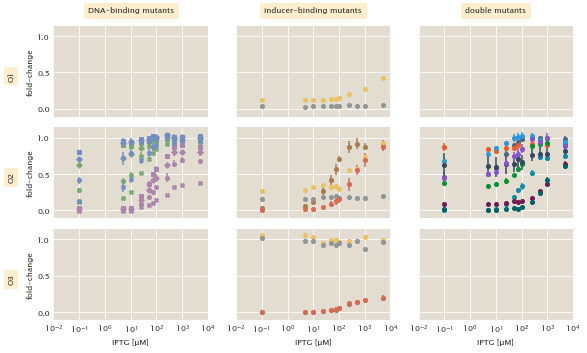

In [4]:
# instantiate the axes
fig, ax = plt.subplots(3, 3, figsize=(8, 5), sharex=True, sharey=True)

# Assign the axes.
class_axes = {'DNA': 0, 'IND': 1, 'DBL': 2}
op_axes = {'O1': 0, 'O2': 1, 'O3': 2}
glyphs = {60: 's', 124: 'D', 260: 'o', 1220: 'X'}

# Add proper labels and formatting.
for i, a in enumerate(ax.ravel()):
    _ = a.xaxis.set_tick_params(labelsize=8)
    _ = a.yaxis.set_tick_params(labelsize=8)
    a.set_xlim([1E-2, 1E4])
    a.set_xscale('log')
    if i % 3 ==0:
        a.set_ylabel('fold-change', fontsize=8)
    if i >= 6:
        a.set_xlabel('IPTG [µM]', fontsize=8)
ax[0, 0].set_title('DNA-binding mutants', fontsize=8, 
                   backgroundcolor=pboc_colors['pale_yellow'], y=1.08)
ax[0, 1].set_title('inducer-binding mutants', fontsize=8, 
                   backgroundcolor=pboc_colors['pale_yellow'], y=1.08)
ax[0, 2].set_title('double mutants', fontsize=8, 
                   backgroundcolor=pboc_colors['pale_yellow'], y=1.08)
for op, ind in op_axes.items():
    ax[ind, 0].text(-0.3, 0.45, op, backgroundcolor=pboc_colors['pale_yellow'], 
                    rotation='vertical', transform=ax[ind, 0].transAxes,
                   fontsize=8)

for g, d in grouped:
    if g[0] != 'WT':
        ax[op_axes[g[1]], class_axes[g[0]]].errorbar(d['IPTGuM'], d['mean'], d['sem'],
                                                     fmt=glyphs[g[-1]], color=colors[g[2]],
                                                    ms=4)

# iterate throughout all grouped strains and plot. 
plt.tight_layout()

It appears that O2 has been the most comprehensively explored operator of all of the data. Some Forays into O1 and O3 for the inducer binding mutants have been performed. This may be useful for elucidating any epistatic effects that may exist (Say with `Q294R` and `Y20I`) 

## Simple Model I: Single-Parameter Family

The most simple model one can imagine for these mutants is that any particular mutant affects only the parameter for that particular domain. For example, mutating only the DNA binding domain should alter only the DNA binding energy $\Delta\varepsilon_{RA}$. Likewise, mutations in the inducer binding domain should alter only the $K_A$ and $K_I$ of the allosteric effector to the active and inactive states of the repressor, respectively.  

There needs to be much thoght into what depth of uncertainty we should included in this analysis. For example, we do have approximate measures of uncertainty for the repressor copy number, DNA binding energy, and $K_A /K_I$. One approach would be to not include *any* uncertainty and take the most-likely parameters as possible delta functions. However, it is possible that mutations in a one domain *could* alter the functionality of the other domains. Our näive assumption is that this doesn't happen, but including the uncertainty in our estimates of the other parameters could shed light on whether or not this is the case. 

Another point that requires some thought is the best way in which to measure the DNA binding energy. There are two viable options from my point of view. 

1. Fit the DNA binding energy *only* from the measurement of leakiness (i.e. $c  = 0$) using the spread of repressor copy numbers. 

2. Use a single strain to fit the DNA binding energy to a complete induction profile, keeping $K_A$ and $K_I$ fixed. In this approach, only one repressor copy number would need to be explored. We could then use the other repressor copy number measurements as a way to assess our predictions. 

In the coming code cells, I explore both of these approaches, each with their own `Stan` models. 

### Estimating $\Delta\varepsilon_{RA}$: Using measurement of leakiness 

When examining only the leakiness, our expression for the fold-change in gene expression simplifies to the following:

$$
\text{fold-change} = \left(1 + {1 \over 1 + e^{-\beta\Delta\varepsilon_{AI}}} {R \over N_{NS}}e^{-\beta\Delta\varepsilon_{RA}}\right)^{-1}.
$$

As we are taking $\Delta\varepsilon_{AI}$ to be a fixed value of 4.5, we are left with a single parameter family fit across a spread of repressor copy numbers. As we will be observing fold-change measurements well below 0.1, this fit should be performed in $\log(\text{fold-change})$ rather than linear. Below, we load the `Stan` model code `DNA_binding_energy_leakiness.stan` and sample the data for the three unique DNA binding mutants. 

In [5]:
# Load the stan model. 
model_code = mut.bayes.assemble_StanModelCode('../stan/DNA_binding_energy_leakiness.stan', 
                                 '../stan/functions.stan')
DNA_leak_model = pystan.StanModel(model_code=model_code) 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4676540ebcd975735311c20af56b497f NOW.


With a compiled model, the data must be properly formatted for sampling. Below, w ignore all measurements of fold-change that are less than zero, apply identification classifiers for mutants and repressor copy numbers, and assemble the complete data dictionary. 

In [6]:
# Prune the data to DNA binding mutants only and enforce positivity.
DNA_data = data[(data['class']=='DNA') & (data['operator']=='O2') & (data['fold_change'] > 0)].copy()

# Assign identifiers for the DNA binding domain mutants. 
DNA_idx = {ind: i+1 for i, ind in enumerate(DNA_data['mutant'].unique())}
REP_idx = {ind:i+1 for i, ind in enumerate(np.sort(DNA_data['repressors'].unique()))}
for mutant, idx in DNA_idx.items():
    DNA_data.loc[DNA_data['mutant']== mutant, 'idx'] = idx
for repressor, idx in REP_idx.items():
    DNA_data.loc[DNA_data['repressors'] == repressor, 'rep_idx'] = idx
DNA_data['idx'] = DNA_data['idx'].astype(int)
DNA_data['rep_idx'] = DNA_data['rep_idx'].astype(int)

# Assign uncertainties for repressor copy numbers from Garcia & Phillips 2011
REP = [60, 124, 260, 1220]
SIG = [20, 30, 40, 160]
# SIG = [0, 0, 0, 0]
REP_SIG = {r:s for r, s in zip(REP, SIG)}

# Assemble the data dictionary for sampling. 
data_dict = dict(J=len(DNA_idx), J_rep=len(REP_idx), N=len(DNA_data),
                 idx=DNA_data['idx'], rep_idx=DNA_data['rep_idx'],
                 R_mu=REP, R_sig=SIG, Nns=4.6E6, n_sites=2, 
                 ep_AI=4.5, foldchange=DNA_data['fold_change'])

With an assembled data structure, we can sample the posterior distribution using NUTS.

In [7]:
samples = DNA_leak_model.sampling(data_dict, iter=5000, chains=4)

In [8]:
# Convert the sampling structure into a dataframe.
DNA_leak_df = mut.bayes.chains_to_dataframe(samples)

# Rename the mutants
new_names = {'ep_RA.{}'.format(ind): 'ep_RA.{}'.format(mut) for mut, ind in DNA_idx.items()}
new_reps = {'R.{}'.format(ind): 'R.{}'.format(int(rep)) for rep, ind in REP_idx.items()}
new_names.update(new_reps)
DNA_leak_df.rename(columns=new_names, inplace=True)

# Compute the statistics
DNA_leak_stats = mut.stats.compute_statistics(DNA_leak_df)

# Compute the long-form dataframe for simple credible region calculation.
DNA_leak_longform = mut.bayes.longform_mcmc_df(DNA_leak_df)
DNA_leak_longform = DNA_leak_longform[DNA_leak_longform['parameter']=='ep_RA'].copy()

With sampling completed, we can compute the best-fit curves as well as the induction curves.   

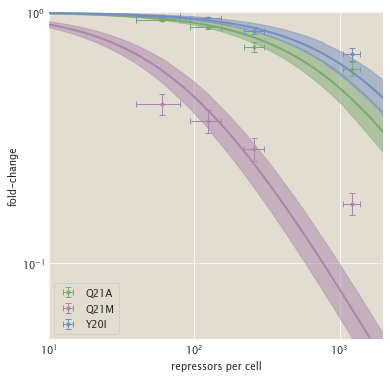

In [9]:
# Instantiate the figure.
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Format axes 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10, 0.2E4])
ax.set_ylim([0.05, 1])

# Add labels
ax.set_xlabel('repressors per cell')
ax.set_ylabel('fold-change')

# Group the fits by mutants.
grouped = DNA_leak_longform.groupby('mutant')

# Define the Architectural parameters.
rep_range = np.logspace(0, 4, 300)
ep_AI = 4.5
for g, d in grouped:
    # Compute the credible regions
    cred_region = np.zeros((2, len(rep_range)))
    pivot = d.pivot(columns='parameter')
    for i, r in enumerate(rep_range): 
        # Instantiate the architecture
        arch = mut.thermo.SimpleRepression(R=r, ep_r=pivot['value']['ep_RA'].values, ep_ai=ep_AI, effector_conc=0, 
                                           ka=1, ki=1, n_sites=2, n_ns=4.6E6).fold_change()
        cred_region[:, i] = mut.stats.compute_hpd(arch, 0.95)
    _ = ax.fill_between(rep_range, cred_region[0, :], cred_region[1, :], alpha=0.5, color=colors[g])
    
    # Compute the best-fit value.
    ep_RA_map = pivot.iloc[np.argmax(pivot['logp'].values)]['value'].values
    best_fit = mut.thermo.SimpleRepression(R=rep_range, ep_r=ep_RA_map[0], ep_ai=ep_AI, effector_conc=0,
                                          ka=1, ki=1, n_sites=2, n_ns=4.6E6).fold_change()
    _ = ax.plot(rep_range, best_fit, lw=2, color=colors[g])

# Plot the data. 
grouped = DNA_data.groupby(['mutant', 'repressors'])
for g, d in grouped:
    mean_fc = np.mean(d['fold_change'])
    sem_fc = np.std(d['fold_change']) / np.sqrt(len(d)) 
    if g[1] == 60:
        label = g[0]
    else:
        label = '__nolegend__'
    _ = ax.errorbar(d['repressors'].unique(), mean_fc, yerr=sem_fc, xerr=REP_SIG[g[1]], lw=1, capsize=3, 
                       color=colors[g[0]], linestyle='none', fmt='o', ms=3, zorder=400, label=label) 
ax.legend()

These fits look okay. As normal, we see that at the high repressor copy numbers the measured fold-change is higher than that predicted by the model. It's interesting that this fit seems to make more sense when performed in linear scale rather than in log. This is an important thing to think about. As the fits look okay, let's plot the predictions and see how well it works.

### On error propagation.
An ongoing problem with this data analysis is the propagation of error. If we were just to plot the predictions using the DNA binding energy we just estimated, we would need to assume that we have  adelta function for the values of $K_A$ and $K_I$. While this may be satisfactory, it will be a bit more fair to propagate our uncertainty in the inducer binding domain from the induction work. 

Ths can be done by writing yet another stan model that samples the data given only very informative priors. The implementation of the bounds given an HPD is an interesting problem that I still don't properly know how to handle. For now, I'll approximate the priors as a normal distribution where the scale parameter is the mean between the upper and lower bounds of the parameter estimate. This `Stan` model can be found as the file `DNA_binding_energy_erroor_prop.stan`.

In [10]:
model_code = mut.bayes.assemble_StanModelCode('../stan/DNA_binding_energy_error_prop.stan',
                                                   '../stan/functions.stan')
error_prop_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e3d4a9dfb1da582478fd798f97e027b1 NOW.


In [11]:
# Properly format the data frame.
O2_data = data[(data['operator']=='O2') & (data['class']=='DNA')].copy()

# Assign identifiers for the DNA binding domain mutants. 
DNA_idx = {ind: i+1 for i, ind in enumerate(O2_data['mutant'].unique())}
REP_idx = {ind:i+1 for i, ind in enumerate(np.sort(O2_data['repressors'].unique()))}
for mutant, idx in DNA_idx.items():
    O2_data.loc[O2_data['mutant']== mutant, 'idx'] = idx
for repressor, idx in REP_idx.items():
    O2_data.loc[O2_data['repressors'] == repressor, 'rep_idx'] = idx
O2_data['idx'] = O2_data['idx'].astype(int)
O2_data['rep_idx'] = O2_data['rep_idx'].astype(int)

# Assign uncertainties for repressor copy numbers from Garcia & Phillips 2011
REP = [60, 124, 260, 1220]
SIG = [20, 30, 40, 160]
REP_SIG = {r:s for r, s in zip(REP, SIG)}

# Include DNA binding energy information. 
ep_RA_mu = [DNA_leak_stats[DNA_leak_stats['parameter']=='ep_RA.{}'.format(m)]['mode'].values[0] for m in O2_data['mutant'].unique()]
ep_RA_sig = [np.diff(DNA_leak_stats[DNA_leak_stats['parameter']=='ep_RA.{}'.format(m)][['hpd_min', 'mode']].values[0])[0] for m in O2_data['mutant'].unique()]
Ka_mu = 139
Ka_sig = 20
Ki_mu = 0.53
Ki_sig = 0.01

# Assemble the data dictionary. 
data_dict = dict(J=len(DNA_idx), J_rep=len(REP_idx), N=len(O2_data), idx=O2_data['idx'],
                rep_idx=O2_data['rep_idx'], R_mu=REP, R_sig=SIG, ep_RA_mu=ep_RA_mu,
                ep_RA_sig=ep_RA_sig, Nns=4.6E6, Ka_mu=Ka_mu, Ka_sig=Ka_sig, Ki_mu=Ki_mu,
                Ki_sig=Ki_sig, n_sites=2, ep_AI=ep_AI, c=O2_data['IPTGuM'], 
                foldchange=O2_data['fold_change'])

In [12]:
# Sample the posterior
error_prop_samples = error_prop_model.sampling(data_dict, iter=5000, chains=4)


In [13]:
error_prop_df = mut.bayes.chains_to_dataframe(error_prop_samples)
new_names = {'ep_RA.{}'.format(ind): 'ep_RA.{}'.format(mut) for mut, ind in DNA_idx.items()}
new_reps = {'R.{}'.format(ind): 'R.{}'.format(int(rep)) for rep, ind in REP_idx.items()}
new_names.update(new_reps)
error_prop_df.rename(columns=new_names, inplace=True)

# Compute the statistics
error_prop_stats = mut.stats.compute_statistics(error_prop_df)

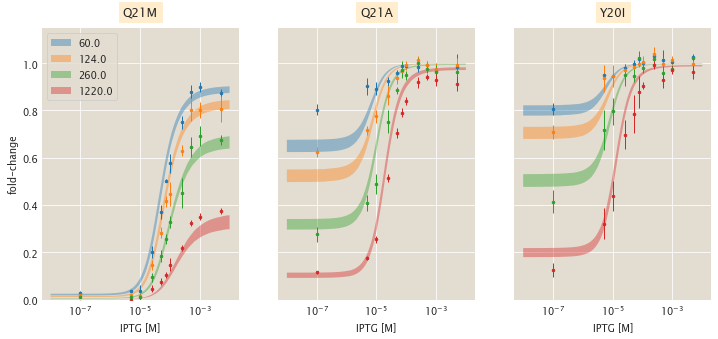

In [58]:
# Instantiate the figure canvas
fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)
ax[0].set_ylabel('fold-change')
for a in ax:
    a.set_xscale('log')
    a.set_xlabel('IPTG [M]')
    a.set_ylim([0, 1.15])

# Find the most likely parameter value. 
mode_ind = np.argmax(error_prop_df['logp'].values)
mode = error_prop_df.iloc[mode_ind]
c_range = np.logspace(-8, -2, 200)
for i, d in enumerate(DNA_idx):
    for j, r in enumerate(REP_idx):
        # Isolate the proper statistics 
        R_mode = mode['R.{}'.format(int(r))]
        epr_mode = mode['ep_RA.{}'.format(d)]
        ka = mode['Ka'] / 1E6
        ki = mode['Ki'] / 1E6
        
        # Compute the mode. 
        fc_prediction = mut.thermo.SimpleRepression(R=R_mode, ep_r=epr_mode, ka=ka, ki=ki, ep_ai=4.5,
                                          effector_conc=c_range).fold_change()
        
        # Compute the credible region
        cred_region = np.zeros((2, len(c_range)))
        for k, c in enumerate(c_range):
            fc = mut.thermo.SimpleRepression(R=error_prop_df['R.{}'.format(int(r))], ep_r=error_prop_df['ep_RA.{}'.format(d)],
                                            ka=error_prop_df['Ka'].values / 1E6, ki=error_prop_df['Ki'].values / 1E6, effector_conc=c,
                                            ep_ai=4.5).fold_change()
            cred_region[:, k] = mut.stats.compute_hpd(fc, mass_frac=0.95)
            
            
        ax_ind = DNA_idx[d] - 1 
#         ax[ax_ind].plot(c_range, fc_prediction, label=int(r))
        ax[ax_ind].fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.4, label=r)
        ax[ax_ind].set_title(d, backgroundcolor=pboc_colors['pale_yellow'], y=1.02)

# Plot the data
DNA_data = mean_fc[(mean_fc['class']=='DNA') & (mean_fc['operator'] == 'O2')].groupby(['mutant', 'repressors'])
for g, d in DNA_data:
    ax_ind = DNA_idx[g[0]] - 1
    ax[ax_ind].errorbar(d['IPTGuM'] / 1E6, d['mean'], d['sem'], linestyle=None, lw=1, fmt='.', ms=5, label='__nolegend__')
ax[0].legend()
plt.savefig('../../figures/full_mcmc_DNA_predictions.pdf', bbox_inches='tight')

This are somewhere inbetween a fit and a prediction. They are predictions fit to data with highly informative priors based off of those obtained in the induction paper. More or less, the model seems to work well with only modifying the DNA binding energy and keeping Ka/Ki restrained for each individualmutant. An interesting exception is the mutant Q21A which appears to be remarkably leaky. The disagreement here is comparable to what we observed with O3 in the induction paper.  